# Evaluation of different classification algorithms for COVID-19 Pandemic Tweets

#### Stylianos Sidiropoulos (stysi607)

#### Text Mining (732A92) - Linköping University

## Load Libraries

In [4]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold

## Data Preprocessing

keep only useful columns, check for nulls, check if dataset is balanced, balance dataset, lowercase words, remove stopwords, punctuations, numbers, links, hashtags, mentions etc.

Dataset: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

In [5]:
# Read data and merge it into one dataset
data = pd.read_csv("https://raw.githubusercontent.com/steliossid/covid19-classification/main/data.csv", encoding="latin")
#data = pd.read_csv("data.csv", encoding="latin")

not_whole_dataset = False

if not_whole_dataset:
    data = data.loc[:1000]
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
# Keep only OriginalTweet and Sentiment columns
data.pop("UserName")
data.pop("ScreenName")
data.pop("Location")
data.pop("TweetAt")
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
# Check if there are null values
data.isnull().values.any()

False

In [8]:
data.shape

(44955, 2)

In [9]:
sentiments = data.Sentiment.unique().tolist()
sentiments

['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']

### Balance Dataset

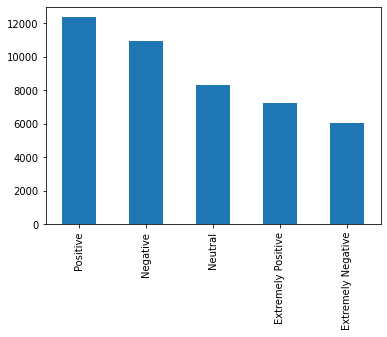

In [10]:
data.Sentiment.value_counts().plot(kind='bar');

In [11]:
data.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

Dataset is not balanced. (should I balance it?)

In [12]:
# Balance dataset
count_min = data.Sentiment.value_counts().min()

# Divide by class and Random undersampling without replacement
df_Pos = data[data.Sentiment == "Positive"].sample(count_min)
df_Neg = data[data.Sentiment == "Negative"].sample(count_min)
df_Neu = data[data.Sentiment == "Neutral"].sample(count_min)
df_ExPos = data[data.Sentiment == "Extremely Positive"].sample(count_min)
df_ExNeg = data[data.Sentiment == "Extremely Negative"]

data_balanced = pd.concat([df_Pos, df_Neg, df_Neu, df_ExPos, df_ExNeg], axis=0)

In [13]:
#data_balanced.Sentiment.value_counts().plot(kind='bar');

In [14]:
data_balanced.Sentiment.value_counts()

Extremely Negative    6073
Extremely Positive    6073
Positive              6073
Neutral               6073
Negative              6073
Name: Sentiment, dtype: int64

In [15]:
# Natural Language Processing (NLP)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def preprocess(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]

In [16]:
data_balanced["ProcessedTweet"] = data_balanced["OriginalTweet"].apply(lambda x: ' '.join(preprocess(x)))
#data["ProcessedTweet"] = data["OriginalTweet"].apply(lambda x: ' '.join(preprocess(x)))
data_balanced.head()

,OriginalTweet,Sentiment,ProcessedTweet
37039,IÂm disproportionately excited by the fact th...,Positive,disproportionately excite fact tomorrow mark d...
25425,Michigan Attorney General cracking down on som...,Positive,michigan attorney general crack shady sleaze b...
4913,To support Spark business customers and New Ze...,Positive,support spark business customer new zealand mo...
28581,How come @JustinTrudeau didn't put a price fre...,Positive,come price freeze item stop hoard price gauge ...
15611,No Touch Grocery Store drive thru opens tomorr...,Positive,touch grocery store drive open tomorrow noon d...


Some rows do not include anything after text processing, so we exclude them

In [17]:
is_empty = data_balanced.ProcessedTweet==""
data_balanced = data_balanced[is_empty==False]

Minor change in the balance of the classes, no need to rebalance the classes

In [18]:
data_balanced.Sentiment.value_counts()

Extremely Negative    6073
Extremely Positive    6073
Negative              6072
Positive              6071
Neutral               6043
Name: Sentiment, dtype: int64

In [19]:
data = data_balanced.copy()

## Statistics

### Number of words in tweet

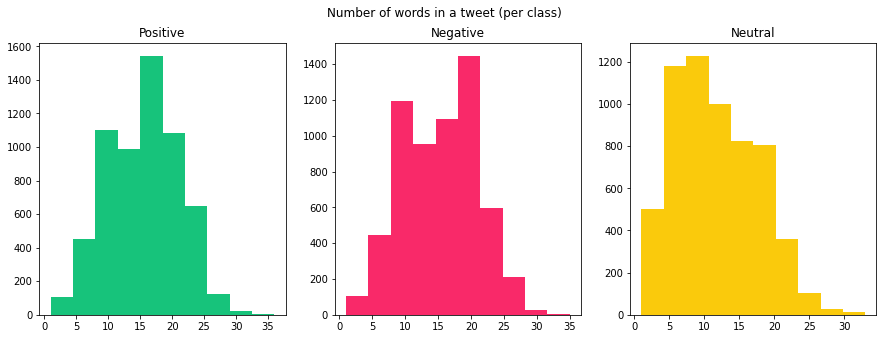

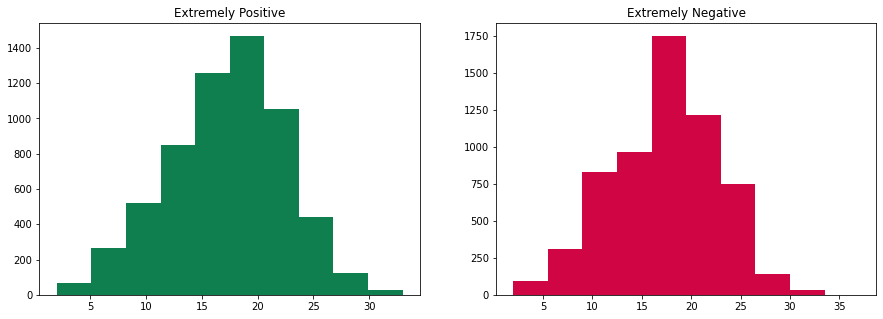

In [20]:
fig1,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig2,(ax4, ax5)=plt.subplots(1,2,figsize=(15,5))

len_pos = data[data['Sentiment']=="Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax1.hist(len_pos, color='#17C37B')
ax1.set_title('Positive')

len_neg = data[data['Sentiment']=="Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax2.hist(len_neg, color='#F92969')
ax2.set_title('Negative')

len_neu = data[data['Sentiment']=="Neutral"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax3.hist(len_neu, color='#FACA0C')
ax3.set_title('Neutral')

len_expos = data[data['Sentiment']=="Extremely Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax4.hist(len_expos, color='#0f7f50')
ax4.set_title('Extremely Positive')

len_exneg = data[data['Sentiment']=="Extremely Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax5.hist(len_exneg, color='#d00644')
ax5.set_title('Extremely Negative')

fig1.suptitle('Number of words in a tweet (per class)')
plt.show()

### Wordclouds

In [21]:
def create_wordlist(sentiment):
    wordlist=[]
    words_removed = ["coronavirus", "coronaviru", "covid19", "covid-19", "covid", "amp"]
    for line in data[data["Sentiment"]==sentiment]["ProcessedTweet"].str.split():
        for word in line:
            if word not in words_removed:
                wordlist.append(word)
    return wordlist

def create_wordcloud(sentiment):
    wordcloud = WordCloud().generate(" ".join(words for words in create_wordlist(sentiment)))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(sentiment + " " + "wordcloud")
    plt.show()

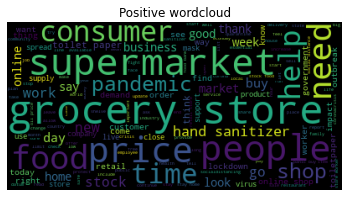

In [22]:
create_wordcloud("Positive")

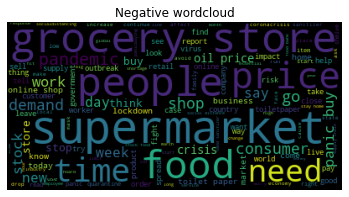

In [23]:
create_wordcloud("Negative")

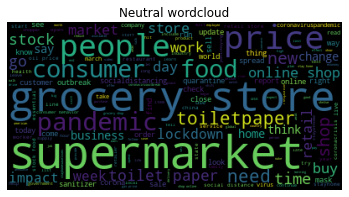

In [24]:
create_wordcloud("Neutral")

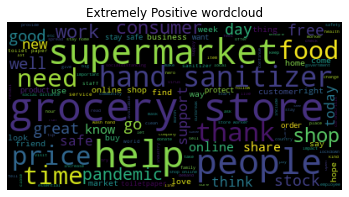

In [25]:
create_wordcloud("Extremely Positive")

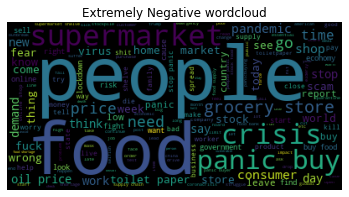

In [26]:
create_wordcloud("Extremely Negative")

In [27]:
def most_common_ngrams(sentiment, n_gram=1, n_common=10):
    wordlist = create_wordlist(sentiment)
    ngrams = zip(*[wordlist[i:] for i in range(n_gram)])
    counter = Counter(' '.join(ngram) for ngram in ngrams)
    return counter.most_common(n_common)

### Uni-grams

In [28]:
most_common_ngrams("Positive")

[('store', 1352),
 ('grocery', 1155),
 ('supermarket', 1105),
 ('food', 1105),
 ('price', 1082),
 ('people', 817),
 ('consumer', 773),
 ('shop', 746),
 ('need', 610),
 ('online', 567)]

In [29]:
most_common_ngrams("Negative")

[('price', 1543),
 ('food', 1356),
 ('store', 1193),
 ('supermarket', 1142),
 ('grocery', 1019),
 ('people', 903),
 ('shop', 696),
 ('buy', 624),
 ('consumer', 604),
 ('panic', 586)]

In [30]:
most_common_ngrams("Neutral")

[('store', 1319),
 ('supermarket', 1107),
 ('grocery', 1015),
 ('price', 907),
 ('consumer', 845),
 ('shop', 699),
 ('food', 613),
 ('online', 557),
 ('people', 488),
 ('toiletpaper', 428)]

In [31]:
most_common_ngrams("Extremely Positive")

[('store', 1420),
 ('grocery', 1084),
 ('supermarket', 1044),
 ('help', 1040),
 ('food', 1027),
 ('hand', 1010),
 ('price', 907),
 ('shop', 894),
 ('sanitizer', 859),
 ('people', 805)]

In [32]:
most_common_ngrams("Extremely Negative")

[('food', 1875),
 ('price', 1627),
 ('panic', 1460),
 ('people', 1437),
 ('supermarket', 1110),
 ('buy', 1096),
 ('store', 1006),
 ('crisis', 885),
 ('grocery', 809),
 ('shop', 639)]

### Bi-grams

In [33]:
most_common_ngrams("Positive", n_gram=2)

[('grocery store', 852),
 ('hand sanitizer', 354),
 ('toilet paper', 217),
 ('online shop', 204),
 ('stay home', 110),
 ('stock food', 93),
 ('social distance', 93),
 ('store worker', 88),
 ('panic buy', 85),
 ('retail store', 83)]

In [34]:
most_common_ngrams("Negative", n_gram=2)

[('grocery store', 782),
 ('panic buy', 309),
 ('oil price', 243),
 ('toilet paper', 205),
 ('online shop', 202),
 ('social distance', 96),
 ('stock food', 93),
 ('food bank', 91),
 ('stay home', 91),
 ('supply chain', 88)]

In [35]:
most_common_ngrams("Neutral", n_gram=2)

[('grocery store', 775),
 ('toilet paper', 243),
 ('online shop', 235),
 ('social distance', 90),
 ('retail store', 87),
 ('consumer behavior', 81),
 ('stock food', 80),
 ('oil price', 76),
 ('shop online', 61),
 ('stay home', 59)]

In [36]:
most_common_ngrams("Extremely Positive", n_gram=2)

[('grocery store', 880),
 ('hand sanitizer', 657),
 ('online shop', 223),
 ('stay safe', 173),
 ('toilet paper', 164),
 ('stay home', 129),
 ('store worker', 125),
 ('shop online', 122),
 ('social distance', 114),
 ('wash hand', 101)]

In [37]:
most_common_ngrams("Extremely Negative", n_gram=2)

[('panic buy', 694),
 ('grocery store', 620),
 ('oil price', 290),
 ('toilet paper', 240),
 ('buy food', 148),
 ('stop panic', 137),
 ('online shop', 122),
 ('supermarket shelve', 115),
 ('food supply', 114),
 ('supply chain', 110)]

## Models

In [38]:
# Split train, test
X = data.ProcessedTweet
y = data.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [39]:
# Vectorizers
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()

### Cross-Validation

In [ ]:
# models = [LogisticRegression(max_iter=100000),
#          MultinomialNB(alpha=0.1),
#          RandomForestClassifier(class_weight='balanced', n_estimators=500, max_depth=50, random_state=0), 
#          DecisionTreeClassifier(random_state=0),
#          LinearSVC(max_iter=100000),
#          SGDClassifier(penalty='l1'),
#          XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=500, use_label_encoder=False)]

models = [LogisticRegression(max_iter=100000, random_state=0),
         MultinomialNB(alpha=0.1),
         RandomForestClassifier(random_state=0), 
         DecisionTreeClassifier(random_state=0),
         LinearSVC(max_iter=100000, random_state=0),
         SGDClassifier(penalty='l1', random_state=0),
         XGBClassifier(use_label_encoder=False, random_state=0)]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tfidf, y_train, scoring='accuracy', cv=CV)
    for kFold, accuracy in enumerate(accuracies):
        entries.append((model_name, kFold, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'kFold', 'accuracy'])

mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

### Best Model (based on CV)

In [ ]:
# CountVectorizer - Logistic Regression
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LogisticRegression(max_iter=100000))
])

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

print(classification_report(y_test, y_predicted))

In [ ]:
plot_confusion_matrix(model, y_test, y_predicted)